In [25]:
import sys 
sys.path.append('/u/dssc/zenocosini/helm_suite/MCQA_Benchmark')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common.config_plot import plot_config
from pathlib import Path
from tqdm import notebook as tqdm
from typing import List, Tuple
from jaxtyping import Float, Int
from common.globals_vars import _NUM_PROC, _OUTPUT_DIR, Array



In [103]:
def cosine_similarity(vec1, vec2):
    """Compute the cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:  # To handle zero division error
        return 0
    return dot_product / (norm_vec1 * norm_vec2)

def angle_between_vectors(
        v1: Float[Array, "d_model"],
        v2: Float[Array, "d_model"]) -> Float:
    """Compute the angle between two vectors."""
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))

def compute_pair_wise_angle(
        matrix: Float[Array, "num_subject d_model"]
        ) -> Float[Array, "num_subjects!/2(num_subjects-1)!"]:
    """Compute the angle between all pairs of vectors in a matrix."""
    # Compute norms for all vectors
    norms = np.linalg.norm(matrix, axis=1)
    
    # Compute dot products for all pairs
    dot_products = np.dot(matrix, matrix.T)
    
    # Compute cosines of angles
    cos_angles = dot_products / np.outer(norms, norms)
    
    # Convert to angles in degrees
    angles = np.degrees(np.arccos(np.clip(cos_angles, -1.0, 1.0)))
    
    # Extract upper triangular part (excluding diagonal)
    angles = angles[np.triu_indices_from(angles, k=1)]

    # flatten angles
    angles = angles.flatten()
    
    return angles

def compute_angle_similarities(
        matrices: Float[Array, "layers num_subject d_model"]
        ) -> Float[Array, "num_matrices - 1"]:
    
    """Compute angle similarities between corresponding rows of consecutive matrices."""
    num_matrices = matrices.shape[0]
    num_subjects = matrices[0].shape[0]
    
    similarities = np.zeros((num_matrices - 1, int((num_subjects*(num_subjects-1))/2)))
    angles = np.zeros((num_matrices - 1, int((num_subjects*(num_subjects-1))/2)))
    for j in tqdm.tqdm(range(num_matrices - 1), desc="Computing angle similarities"):
        matrix_1, matrix_2 = matrices[j], matrices[j + 1]
        
        if matrix_1.shape != matrix_2.shape:
            raise ValueError("Matrices must have the same shape")

        # angles_1 = np.array([compute_pair_wise_angle(m) for m in matrix_1])
        # angles_2 = np.array([compute_pair_wise_angle(m) for m in matrix_2])
        angles_1 = compute_pair_wise_angle(matrix_1)        
        angles_2 = compute_pair_wise_angle(matrix_2)
        assert angles_1.shape[0] == ((matrix_1.shape[0])*(matrix_1.shape[0]-1))/2,\
            f"angles_1 shape: {angles_1.shape} instead of {((matrix_1.shape[0])*(matrix_1.shape[0]-1))/2}"
        angles[j] = angles_1

        similarities[j] = np.abs(angles_1 - angles_2)
    
    return similarities.mean(-1), angles
    

def compute_cosine_similarities(matrices):
    """Compute cosine similarities between corresponding rows of consecutive matrices."""
    similarities = []
    num_matrices = len(matrices)

    for j in range(num_matrices - 1):
        matrix_1 = matrices[j]
        matrix_2 = matrices[j + 1]
        
        if matrix_1.shape[0] != matrix_2.shape[0]:
            raise ValueError("Matrices must have the same number of rows")

        row_similarities = []
        for i in range(matrix_1.shape[0]):
            sim = cosine_similarity(matrix_1[i], matrix_2[i])
            row_similarities.append(sim)
        similarities.append(row_similarities)
    
    return np.asarray(similarities)

#




In [ ]:
def average_custom_blocks(y, n):
    # Initialize lists to store averages
    y_avg = []

    # Handle the first block [0:n]
    
    y_avg.append(np.mean(y[0:n]))
    
    # Handle the second block [0:n+1]
    if len(y) > n:
        
        y_avg.append(np.mean(y[0:n+1]))

    # Handle subsequent blocks [i:n+i] starting from i=1
    for i in range(1, len(y)-1):
        
        y_avg.append(np.mean(y[i:n+i+1]))
    assert len(y_avg) == len(y), f"y_avg:{len(y_avg)}, y:{len(y)}"

    return np.array(y_avg)

In [117]:
subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 
 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 
 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics',
'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 
'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 
'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics',
'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history',
'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management',
'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 
 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']

indices = [subjects.index('high_school_mathematics'),
subjects.index('high_school_physics'),
subjects.index('high_school_computer_science'),
subjects.index('college_mathematics'),
subjects.index('college_physics'),
subjects.index('abstract_algebra'),
subjects.index('high_school_statistics'),
subjects.index('elementary_mathematics'),]

indices = [subjects.index('high_school_mathematics'),
subjects.index('college_mathematics'),
subjects.index('abstract_algebra'),
subjects.index('elementary_mathematics'),]


In [131]:




def query_data(data, model, train_instances, method, algorithm):
    """ Helper function to query data based on specified criteria. """
    query_string = f"model=='{model}'" \
                   f"and shot=={train_instances}" \
                   f"and method=='{method}'" 
    if algorithm == "weights":
        weights = data.query(query_string)['weights'].iloc[0]
        cos_sim = compute_cosine_similarities(weights) # (num_layers, num_subject)
        return cos_sim.mean(axis=1)
    elif algorithm == "preserved_angles":
        weights = data.query(query_string)['weights'].iloc[0]
        print(weights.shape)
        sim, angles = compute_angle_similarities(weights) # (num_layers, num_subject)
        return sim, angles
    else:
        return np.stack(data.query(query_string)[algorithm].iloc[0])

def determine_shot(model):
    """ Determine the shot number based on model name. """
    return 4 if "70" in model else 5

def plot_label_probe(models, data, title, folder_prompt, label, avg=False, n=3):
    """ 
    Plot overlap of labels for given models and data.
    
    Args:
    models : list of model identifiers
    data : DataFrame containing the data
    z : class fraction to be used in querying data
    title : title for the plot
    """
    
    shot = determine_shot(models[0])

    algorithm = "weights"
    algorithm = "preserved_angles" 
    # Query data for plotting
    clustering_label1 = query_data(data, models[0], '0', 'last', algorithm)
    clustering_label2 = query_data(data, models[0], '1', 'last', algorithm)
    clustering_label3 = query_data(data, models[0], '2', 'last', algorithm)
    clustering_label4 = query_data(data, models[0], str(shot), 'last', algorithm)
    # clustering_label5 = query_data(data, models[1], '0', 'last', z, algorithm)
    if len(models) > 1:
        clustering_label6 = query_data(data, models[1], '0', 'last', algorithm)
    if avg:
        clustering_label1 = average_custom_blocks(clustering_label1, n)
        clustering_label2 = average_custom_blocks(clustering_label2, n)
        clustering_label3 = average_custom_blocks(clustering_label3, n)
        clustering_label4 = average_custom_blocks(clustering_label4, n)
        # clustering_label5 = average_custom_blocks(clustering_label5, n) 
        if len(models) > 1:
            clustering_label6 = average_custom_blocks(clustering_label6, n)

    # Set up plot styles
    sns.set_style(
        "whitegrid",
        rc={"axes.edgecolor": ".15", "xtick.bottom": True, "ytick.left": True},
    )
    layers = np.arange(0, clustering_label1.shape[0])


    # Initialize figure
    plt.figure(dpi = 200)
    
    # Plot data
    sns.scatterplot(x=layers, y=clustering_label1)  
    sns.scatterplot(x=layers, y=clustering_label2)  
    sns.scatterplot(x=layers, y=clustering_label3)
    sns.scatterplot(x=layers, y=clustering_label4)  
    sns.lineplot(x=layers, y=clustering_label1, label=f"0 shot pt")
    sns.lineplot(x=layers, y=clustering_label2, label=f"1 shot pt")
    sns.lineplot(x=layers, y=clustering_label3, label=f"2 shot pt")
    sns.lineplot(x=layers, y=clustering_label4, label=f"5 shot pt")
    if len(models) > 1:
        sns.lineplot(x=layers, y=clustering_label6, label=f"0 shot {'ft' if 'ft' in models[1] else 'chat'}")
        sns.scatterplot(x=layers, y=clustering_label6, markers="X")  
    
    # Finalizing plot
    tick_positions = np.arange(0,clustering_label1.shape[0], 4).round(3)  # Generates positions 0, 4, 8, ...
    
        
    plt.xticks(ticks=tick_positions, labels=tick_positions+1)
    
    plt.xlabel("layer")
    algo = "Probe"
    plt.ylabel("Angle Similarity")
    plt.legend()
    complete_title = title
    plt.title(complete_title)
    plt.rcParams.update(plot_config)
    plt.tight_layout()
    folder = label.lower()
    path_save = Path(f"pics/{folder_prompt}/{algo.lower()}/{folder}")
    path_save.mkdir(parents=True, exist_ok=True)
    print(path_save)
    avg_n = f"_avg_{n}" if avg else ""
    # save in pdf
    plt.savefig(path_save / f"{complete_title.lower().replace(' ', '_')}{avg_n}_log.pdf")
    plt.savefig(path_save / f"{complete_title.lower().replace(' ', '_')}{avg_n}_log.png")
    plt.show()

# Commented to prevent execution
# plot_label_overlap(["model70", "model80"], pd.DataFrame(), 0.5, "Sample Title")


In [132]:
sim, angles = query_data(data, models[0], 5, 'last', "preserved_angles")
 # TODO check order of magnitude angles

(33, 57, 4096)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_214550/1515705629.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


In [138]:
couples = []
for i in range(len(subjects)):
    for j in range(i+1, len(subjects)):
        if i != j:
            couples.append((subjects[i],subjects[j]))

In [144]:
indices_to_check = [n for n,k in enumerate(couples) if "physics" in k[0] and "history" in k[1]]


In [150]:
np.max(angles[2:])

114.7367646328342

(33, 57, 4096)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

(33, 57, 4096)


/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

(33, 57, 4096)


/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

(33, 57, 4096)


/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

(33, 57, 4096)


/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


pics/probe/subject


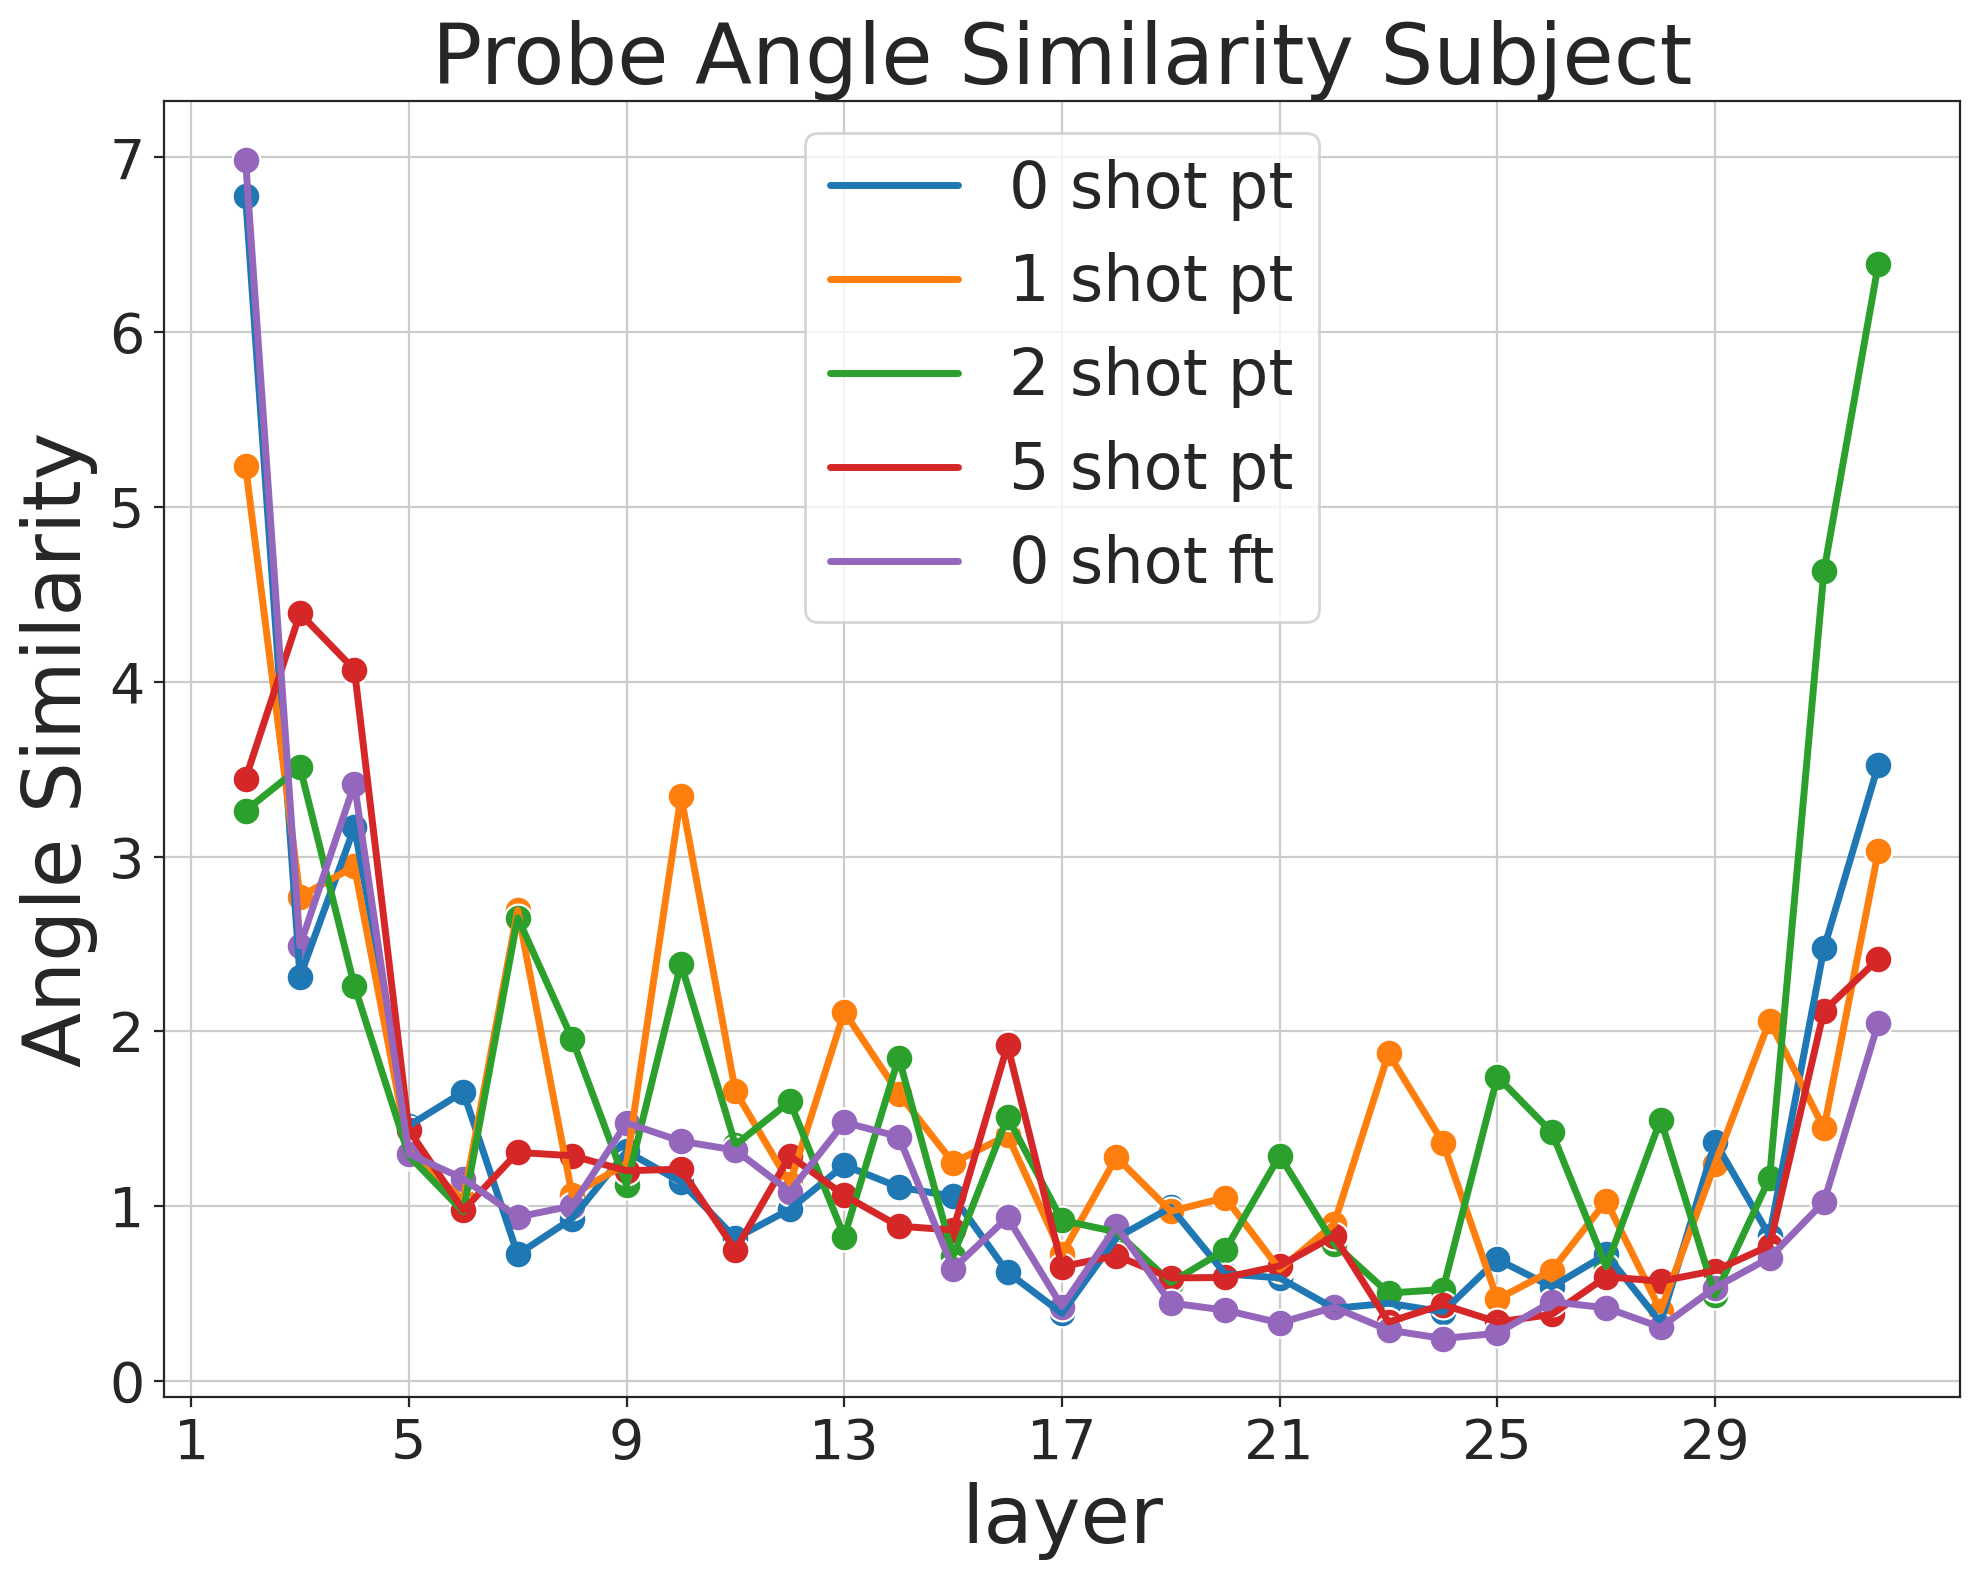

In [98]:
label_alias = {"Subject": "dataset", "Letter": "only_ref_pred"}
label = "Subject"
folder = "probe_3_8b_weights"
folder = "probe_logistic"

result_path = "/orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset"
data = pd.read_pickle(result_path+f"/{folder}/probe_{label_alias[label]}.pkl")
models = ["llama-3-8b", "llama-3-8b-ft"]
title = f"Probe Angle Similarity {label}"


plot_label_probe(models, data, title, "", label, avg=False, n=3)
 #plot_label_probe(models, data, title, folder_prompt, label, avg=False, n=3)

(33, 57, 4096)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

(33, 57, 4096)


/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


(33, 57, 4096)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

(33, 57, 4096)


/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


(33, 57, 4096)


Computing angle similarities:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_214550/3644918365.py:28: RuntimeWarning: invalid value encountered in divide
  cos_angles = dot_products / np.outer(norms, norms)


pics/probe/subject


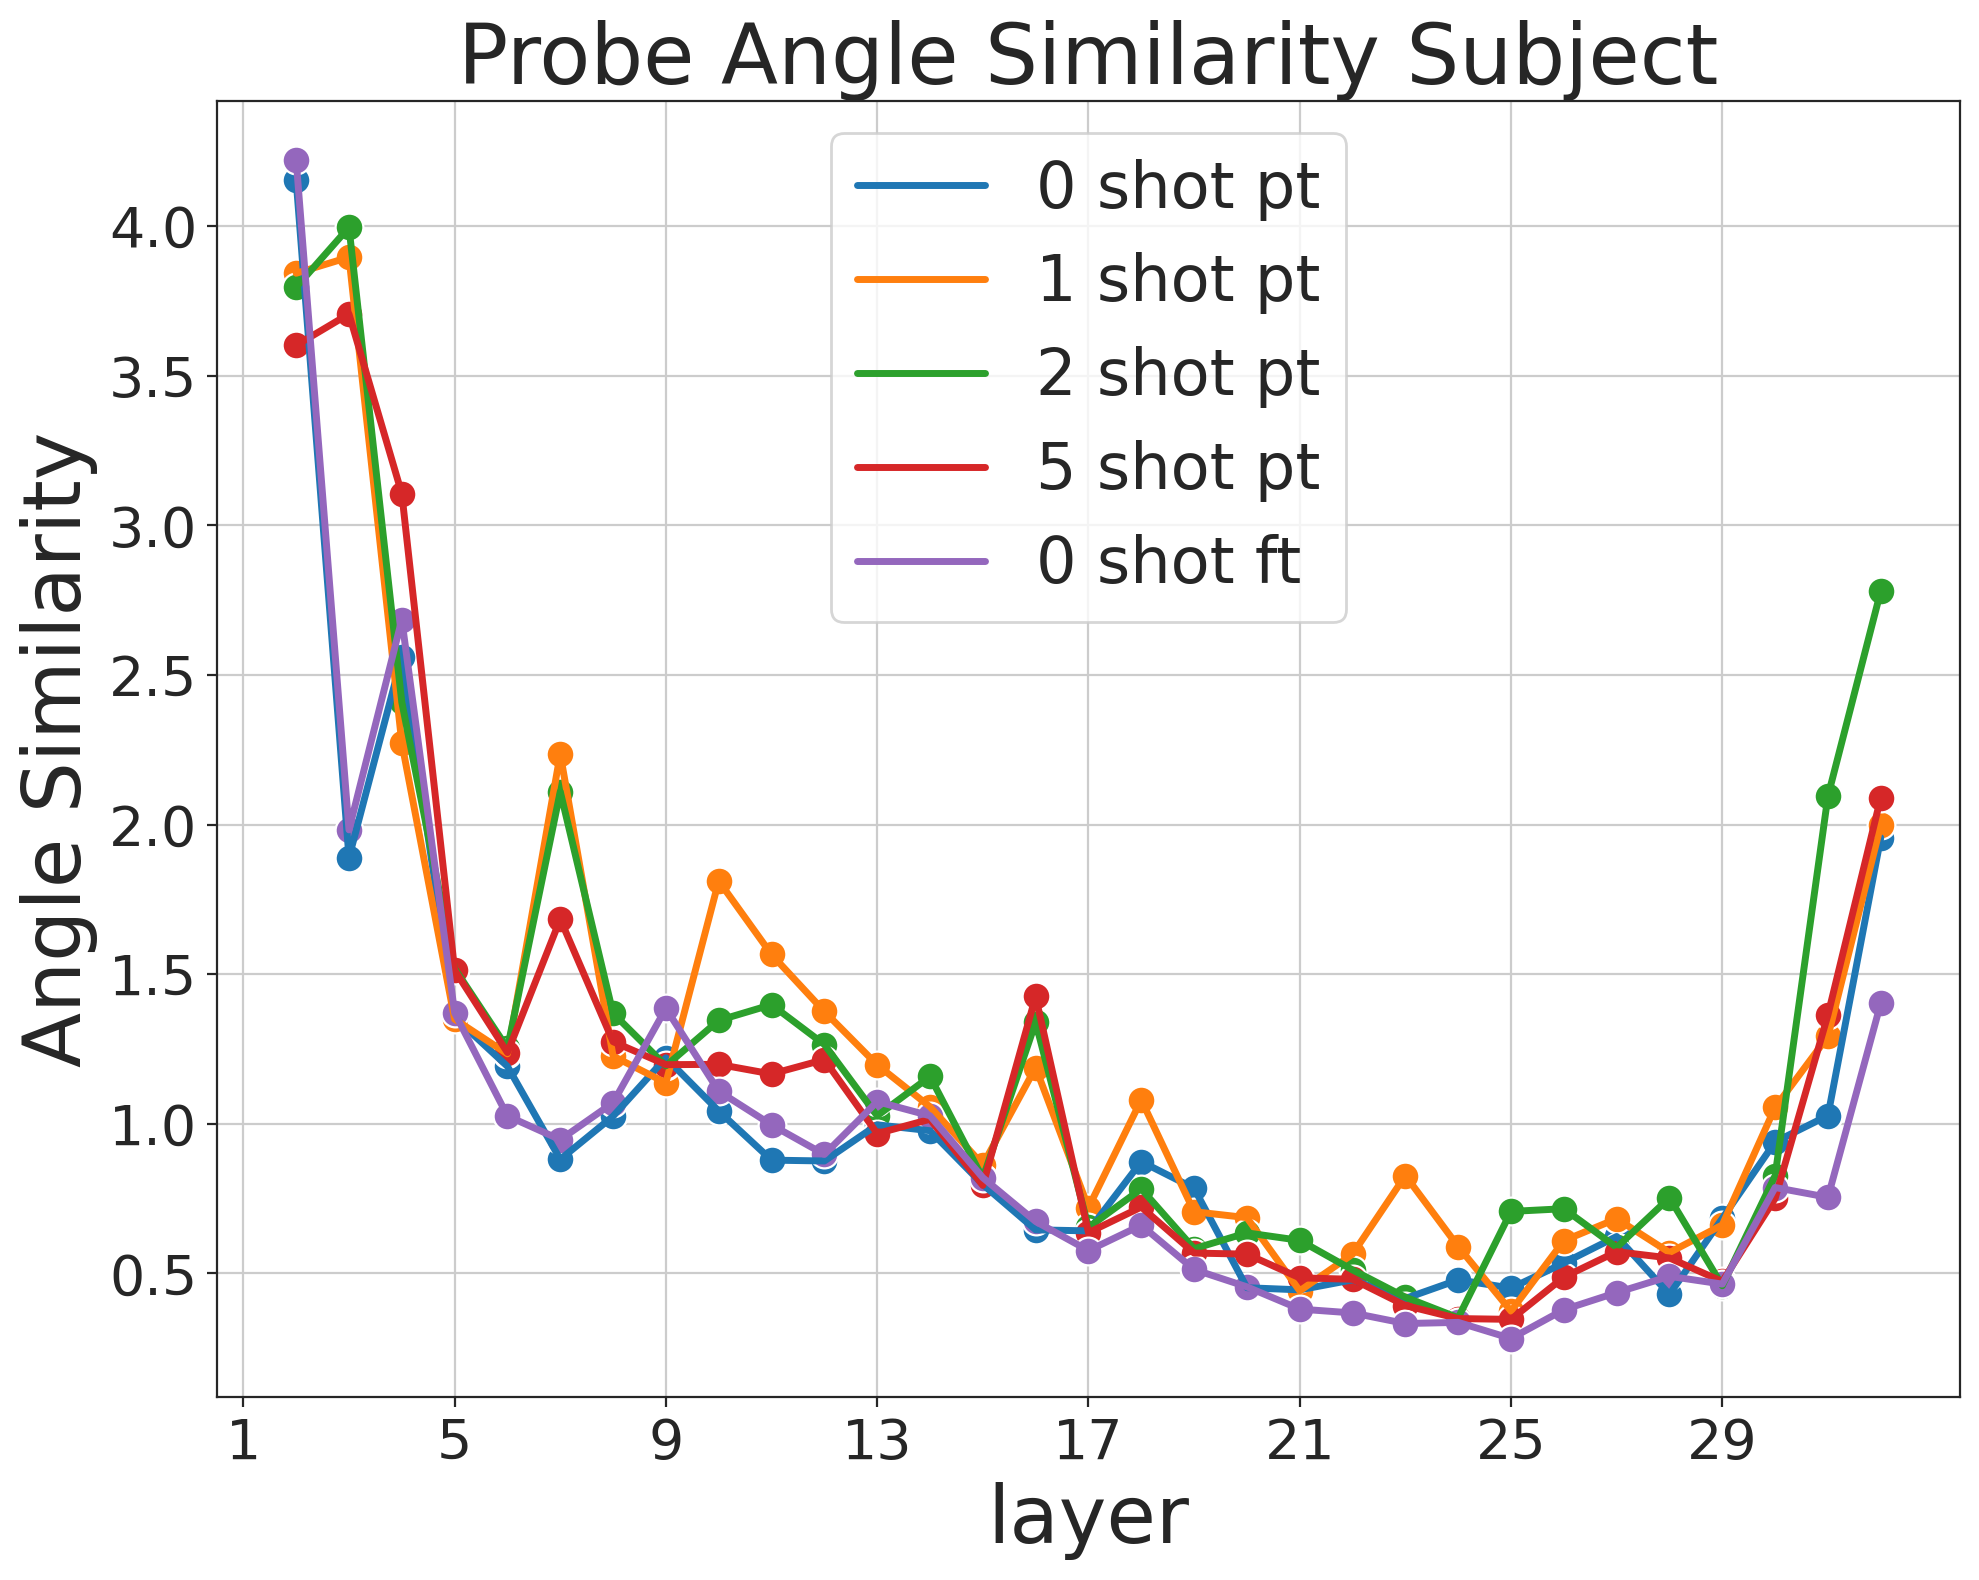

In [100]:
plot_label_probe(models, data, title, "", label, avg=False, n=3)